In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from shapely.geometry import Polygon, Point, LineString
import pandas as pd
import geopandas as gpd
import folium
from IPython.display import Image
import selenium.webdriver
import shapely.geometry
import osmnx as ox
import pyproj
from geojson.feature import Feature, FeatureCollection
from shapely.geometry import Point, Polygon, LineString
import h3
import json
import branca.colormap as cmp
import glob
from statistics import *
import matplotlib.pyplot as plt

In [3]:
import os
cwd = os.getcwd()
os.chdir(os.path.join(cwd,'..\..\..'))

In [4]:
import ExMAS.main
import ExMAS.utils
import seaborn as sns

In [5]:
from ExMAS.utils import inData as inData
import glob

In [6]:
def ride_finder(dem, disc):
    dem = "_"+str(dem)+"_"
    disc= "_"+str(disc).replace(".","")+"_"
    rides = glob.glob('ExMAS/data/results3/rides/*.csv', recursive=True)
    rides  = [s for s in rides if dem in s]
    rides = [s for s in rides if disc in s]
    return rides

def sched_finder(dem, disc):
    dem = "_"+str(dem)+"_"
    disc= "_"+str(disc).replace(".","")+"_"
    sched = glob.glob('ExMAS/data/results3/sched/*.csv', recursive=True)
    sched = [s for s in sched if dem in s]
    sched = [s for s in sched if disc in s]
    return sched

def req_finder(dem, disc):
    dem = "_"+str(dem)+"_"
    disc= "_"+str(disc).replace(".","")+"_"
    req = glob.glob('ExMAS/data/results3/requests/*.csv', recursive=True)
    req  = [s for s in req if dem in s]
    req = [s for s in req if disc in s]
    return req
    

In [7]:
def repli_format_hexi(df_ride, df_req):
    resop = pd.DataFrame(columns=['lambda_r','u','u_sh','u_r','degree','origin','destination'])
    #resop = resop.fillna(0)

    for req,file in enumerate(df_ride):                               #looping through all the replications

        file_ride = pd.read_csv(file)                                 #reading a specific file
        file_req = pd.read_csv(df_req[req])
        org  = file_req['origin']
        dest = file_req['destination']
        u = file_req['u']                                               
        u_sh = file_req['u_sh']
        for i in range(len(file_ride)):                               #looping through all the rows
            a = file_ride['lambda_r'].iloc[i]                         
            b = json.loads(file_ride['indexes_orig'].iloc[i])
            c = json.loads(file_ride['indexes_dest'].iloc[i])
            deg = file_ride['kind'].iloc[i]
            u = file_req['u']                                               
            u_sh = file_req['u_sh']
            if 20<=deg<30:
                deg=2
            elif 30<=deg<40:
                deg=3
            elif 40<=deg<50:
                deg=4
            elif deg>=50:
                deg=5
            else:
                deg=1
#             for j in range(len(b)):                                                              #loop adds all the passenger origins to dataframe
#                 resop = resop.append({'lambda_r':a,'origin':org[b[j]],'destination':dest[c[j]],\
#                                       'x':org[b[j]],'y':org[b[j]],'degree':deg},ignore_index=True)
            
            resop = resop.append({'lambda_r':a,'u':u[b[0]],'u_sh':u_sh[b[0]],'origin':org[b[0]],'destination':dest[c[0]],\
                                  'x':org[b[0]],'y':org[b[0]],'degree':deg},ignore_index=True) #adding only the first passenger picked up
    
    resop['u_r'] = (resop['u_sh']-resop['u'])/resop['u_sh']        
    resop['x'] = resop['x'].apply(lambda row: inData.nodes.loc[row].x)                           #applying x/y coordinates
    resop['y'] = resop['y'].apply(lambda row: inData.nodes.loc[row].y)


    #resop = pd.concat(resop)
    resop_s = resop[resop['degree']>1]  #filter only sharing rides
    return resop,resop_s                #choice of selecting all rides or only shared rides

In [8]:
def hexator(inData,res, APERTURE_SIZE = 8, threshold = 1, col = 'u_diff'):
    res['hex_o_{}'.format(APERTURE_SIZE)] = res.apply(lambda row: h3.geo_to_h3(row.y,row.x,APERTURE_SIZE),axis = 1) 
    trips = res
    
    col_geom = 'hex_o_{}'.format(APERTURE_SIZE)
    hexes = pd.Series(list(set(list(trips[col_geom].unique())+list(trips[col_geom].unique())))).to_frame(col_geom)
    hexes = hexes.set_index(col_geom)
    hexes[col_geom] = hexes.index.copy()
    hexes['nobs'] = trips.groupby(col_geom).size()
    hexes = hexes[hexes['nobs']>threshold]
    hexes['geom'] = hexes.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x[col_geom], geo_json = True)]}, axis = 1)
    aggr = trips.groupby(col_geom)[col]                                           #hexes(col) grouped with the geometry of hex
    hexes['nobs'] = aggr.size()
    hexes[col] = aggr.mean()                                                       #mean of values within a hexagon taken
    hexes[col+'_std'] = aggr.std()                                                 #standard deviation of values within a hexagon taken
    hexes['co_var'] = hexes[col+'_std']/hexes[col].abs()                           #std of hexagon divided by its mean.
    return hexes['co_var']                                                         #column of co_variance of hexes.
    

In [9]:
params = ExMAS.utils.get_config('ExMAS/data/configs/my_config.json') # load the default 

In [10]:
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [11]:
inData = ExMAS.utils.load_albatross_csv(inData, params, sample=True)

In [83]:
demand = [400,600,800,1000,1400,1800,2200,2600,3000]
price = [0.15,0.2,0.25,0.3,0.35]

In [84]:
#Empty dataframes created for lambda/u_r/degree

df_lam = pd.DataFrame(columns = ['demand','0.15','0.2','0.25','0.3','0.35'])
df_lam['demand']=demand
df_lam=df_lam.fillna(0)
df_lam=df_lam.set_index('demand')

df_u_r = df_lam.copy()

df_deg = df_lam.copy()

In [85]:
#Generating data to enter into the Dataframes

for p in price:
    
    if p == 0.35:
        demand = [400,600,800,1000,1400,1800,2200,2600]
    for dem in demand:
        ride  = sched_finder(dem,p)
        reqs  = req_finder(dem,p)
        resop = repli_format_hexi(ride,reqs)
        a = hexator(inData,resop[1],col='lambda_r').mean() #taking mean of all the hexagons for each discount and demand
        b = hexator(inData,resop[0],col='u_r').mean()
        c = hexator(inData,resop[0],col='degree').mean()
        df_lam[str(p)].loc[dem]=a           
        df_u_r[str(p)].loc[dem]=b 
        df_deg[str(p)].loc[dem]=c
    print("------")
    print(p)
    print(dem)
    print('------')

------
0.15
3000
------
------
0.2
3000
------
------
0.25
3000
------
------
0.3
3000
------
------
0.35
2600
------


In [16]:
df = pd.read_csv('ExMAS/data/plots2.csv').set_index('demand')

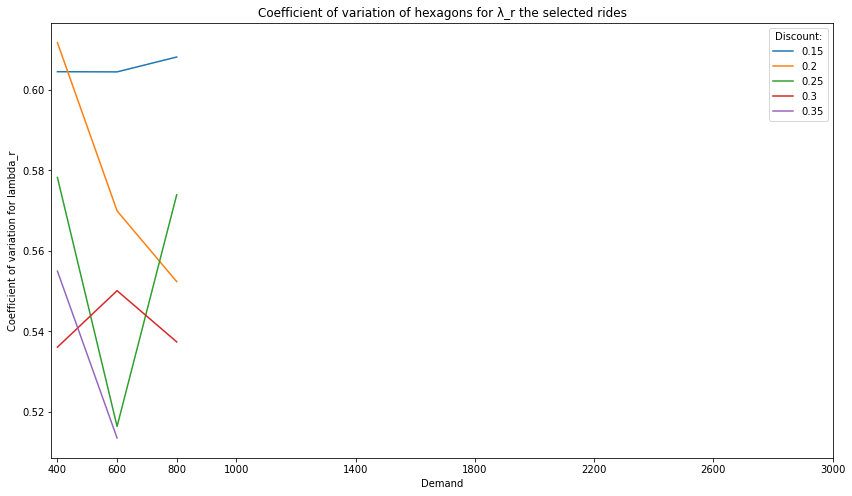

In [82]:
x_ax=[400,600,800,1000,1400,1800,2200,2600,3000]
plt.figure(figsize=(14,8))
df_lamm = df_lam
for i,p in enumerate(price):
    if p == 0.35: 
        df_lamm=df_lamm[:-1]
        x_ax=[400,600,800,1000,1400,1800,2200,2600]
    plt.plot(df_lamm.index,df_lamm[str(p)], label = p)
x_ax=[400,600,800,1000,1400,1800,2200,2600,3000]
plt.xlabel('Demand')
plt.ylabel('Coefficient of variation for lambda_r')
plt.xticks(x_ax)
plt.title('Coefficient of variation of hexagons for \u03BB_r the selected rides')
plt.legend(title='Discount:',loc='best')
plt.show()

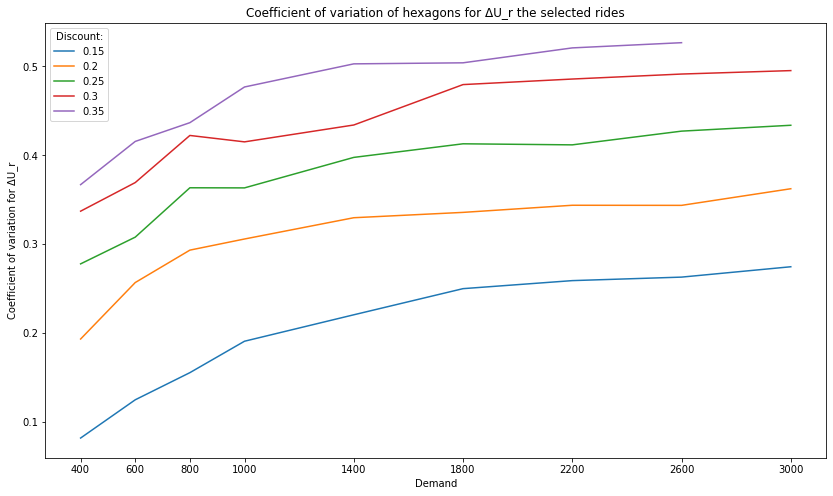

In [27]:
x_ax=[400,600,800,1000,1400,1800,2200,2600,3000]
plt.figure(figsize=(14,8))
df_u_rr = df_u_r
for i,p in enumerate(price):
    if p == 0.35: 
        df_u_rr=df_u_rr[:-1]
        x_ax=[400,600,800,1000,1400,1800,2200,2600]
    plt.plot(df_u_rr.index,df_u_rr[str(p)], label = p)
x_ax=[400,600,800,1000,1400,1800,2200,2600,3000]
plt.xlabel('Demand')
plt.ylabel('Coefficient of variation for \u0394U_r')
plt.xticks(x_ax)
plt.title('Coefficient of variation of hexagons for \u0394U_r the selected rides')
plt.legend(title='Discount:',loc='best')
plt.show()

# Ignore this below

AttributeError: 'Figure' object has no attribute 'subtitle'

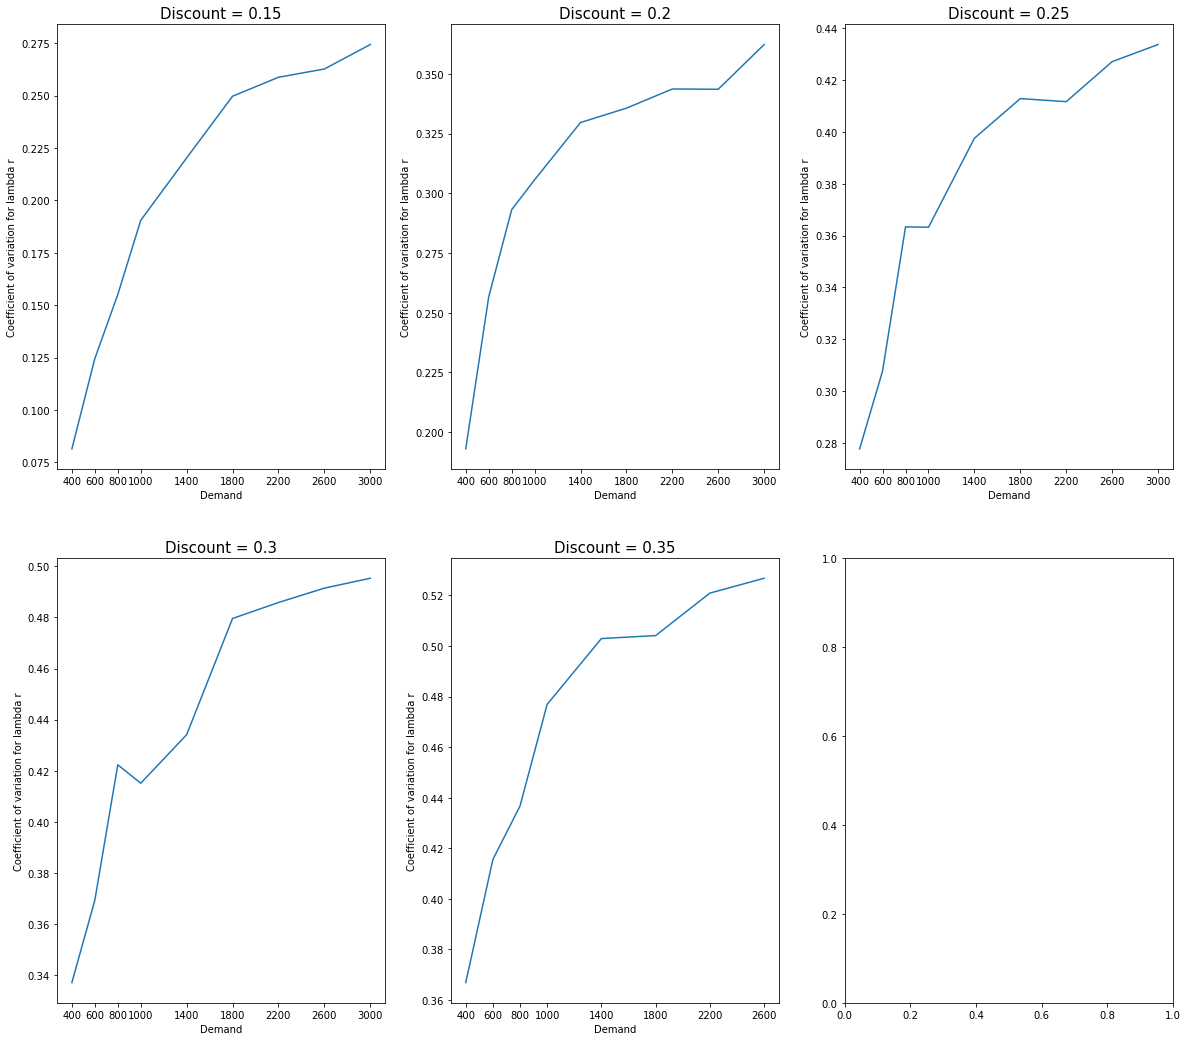

In [22]:
x_ax=np.array([400,600,800,1000,1400,1800,2200,2600,3000])
fig, axes = plt.subplots(2, 3, figsize = (20,18 ))
for i,p in enumerate(price):
    if p == 0.35:
        df_u_r=df_u_r[:-1]
        x_ax=np.array([400,600,800,1000,1400,1800,2200,2600])
    ax = axes.flatten()[i]
    ax.plot(df_u_r.index,df_u_r[str(p)], label = p)
    ax.set_xlabel('Demand')
    ax.set_ylabel('Coefficient of variation for lambda r')
    ax.set_xticks(x_ax)
    ax.set_title('Discount = {}'.format(p),fontsize=15)
fig.subtitle('Coefficient of variation within hexagons for selected rides',y=1)
plt.show()


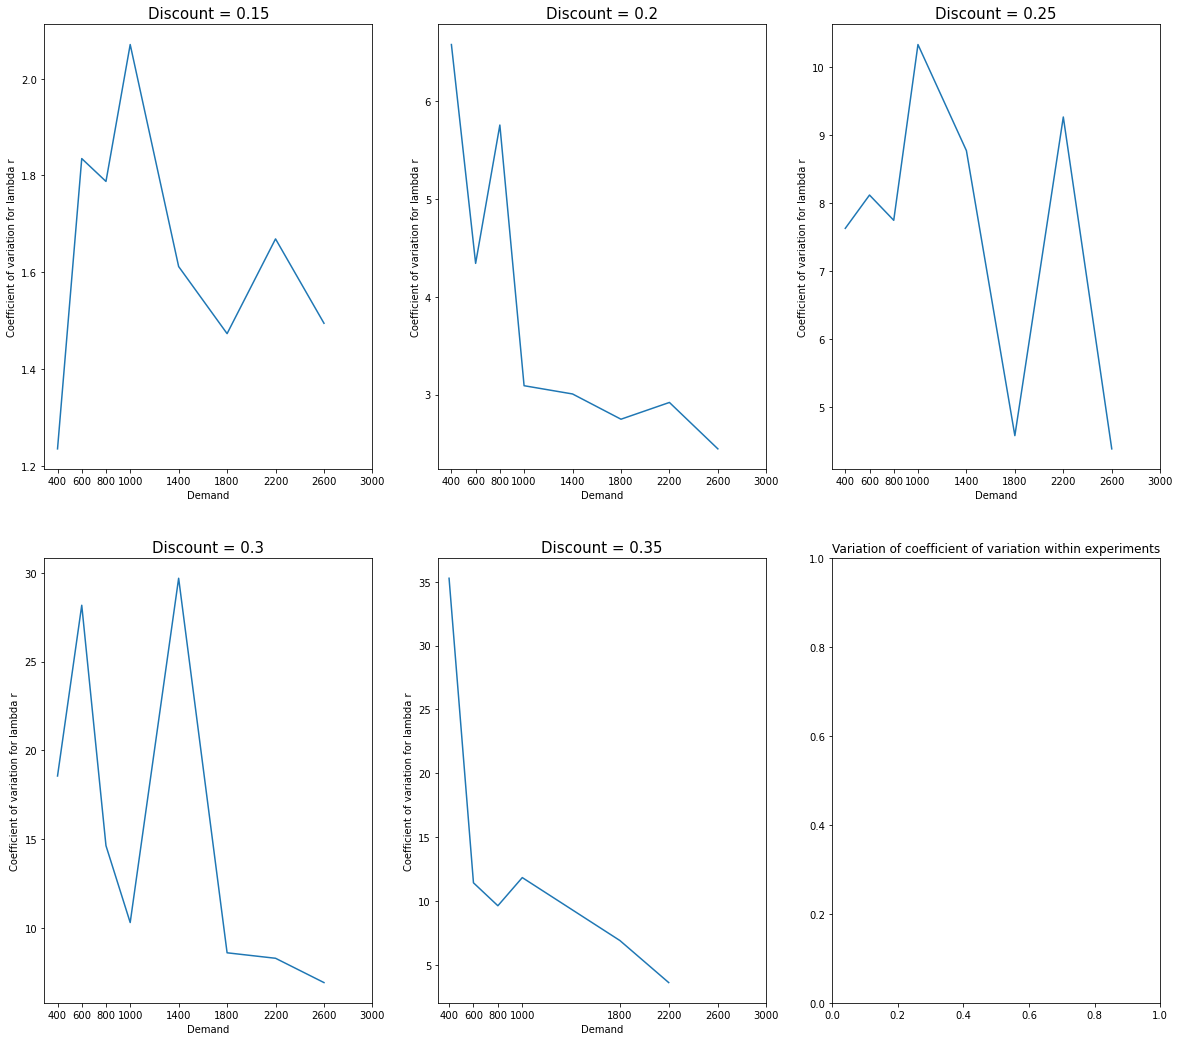

In [56]:
x_ax=np.array([400,600,800,1000,1400,1800,2200,2600,3000])
df_2=df
fig, axes = plt.subplots(2, 3, figsize = (20,18 ))
for i,p in enumerate(price):
    if p == 0.35:
        df_2=df_2.drop(1400)
        df_2=df_2[:-1]
        x_ax=np.array([400,600,800,1000,1800,2200,2600,3000])
    ax = axes.flatten()[i]
    ax.plot(df_2.index,df_2[str(p)], label = p)
    ax.set_xlabel('Demand')
    ax.set_ylabel('Coefficient of variation for lambda r')
    ax.set_xticks(x_ax)
    ax.set_title('Discount = {}'.format(p),fontsize=15)
fig.subtitle('Coefficient of variation within hexagons for all feasible rides',y=1)
plt.show()


plt.show()

In [ ]:
prices = [df_015, df_02,df_025,df_03,df_035]
price  = [0.15,0.2,0.25,0.3,0.35]

fig, axes = plt.subplots(3, 2, figsize = (20,18 ))
l=0
for i,k in enumerate(prices):
    l, j = divmod(i, 2)
    
    sns.boxplot(x='index', y='mean_lambda_r',data=k, palette="Set3",orient='v',ax=axes[l,j])\
    .set_title('Discount = {}'.format(price[i]),fontsize=15)
    #ax.set_axis_off();
label = str('Boxplots of mean_lambda_r for the replications conducted')
fig.suptitle(label,y=1,fontsize=20)
fig.subplots_adjust(top=0.88)
plt.tight_layout()
plt.show()